<a href="https://colab.research.google.com/github/deconasser/NeoPolyps/blob/main/TestUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

In [2]:
import os
from torch.utils.data import Dataset
from PIL import Image

class UNetTestDataClass(Dataset):
    def __init__(self, images_path, transform):
        super(UNetTestDataClass, self).__init__()

        images_list = os.listdir(images_path)
        images_list = [images_path+i for i in images_list]

        self.images_list = images_list
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.images_list[index]
        data = Image.open(img_path)
        h = data.size[1]
        w = data.size[0]
        data = self.transform(data) / 255
        return data, img_path, h, w

    def __len__(self):
        return len(self.images_list)

In [6]:
import torch
import cv2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = '/content/drive/MyDrive/Unet/test/'
transform = Compose([Resize((512, 512), interpolation=InterpolationMode.BILINEAR), PILToTensor()])
unet_test_dataset = UNetTestDataClass(path, transform)
test_dataloader = DataLoader(unet_test_dataset, batch_size=8, shuffle=True)
# Model path
pretrained_path = '/content/drive/MyDrive/Unet/checkpoints(2)'
num_classes = 3

def weights_init(model):
    if isinstance(model, nn.Linear):
        # Xavier Distribution
        torch.nn.init.xavier_uniform_(model.weight)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
from collections import OrderedDict

model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
)


try:
    checkpoint = torch.load(pretrained_path)
    new_state_dict = OrderedDict()
    for k, v in checkpoint['model'].items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    # load params
    model.load_state_dict(new_state_dict)
    model = nn.DataParallel(model)
    model.to(device)
except:
    model.apply(weights_init)
    model = nn.DataParallel(model)
    model.to(device)

torch.Size([8, 3, 512, 512])


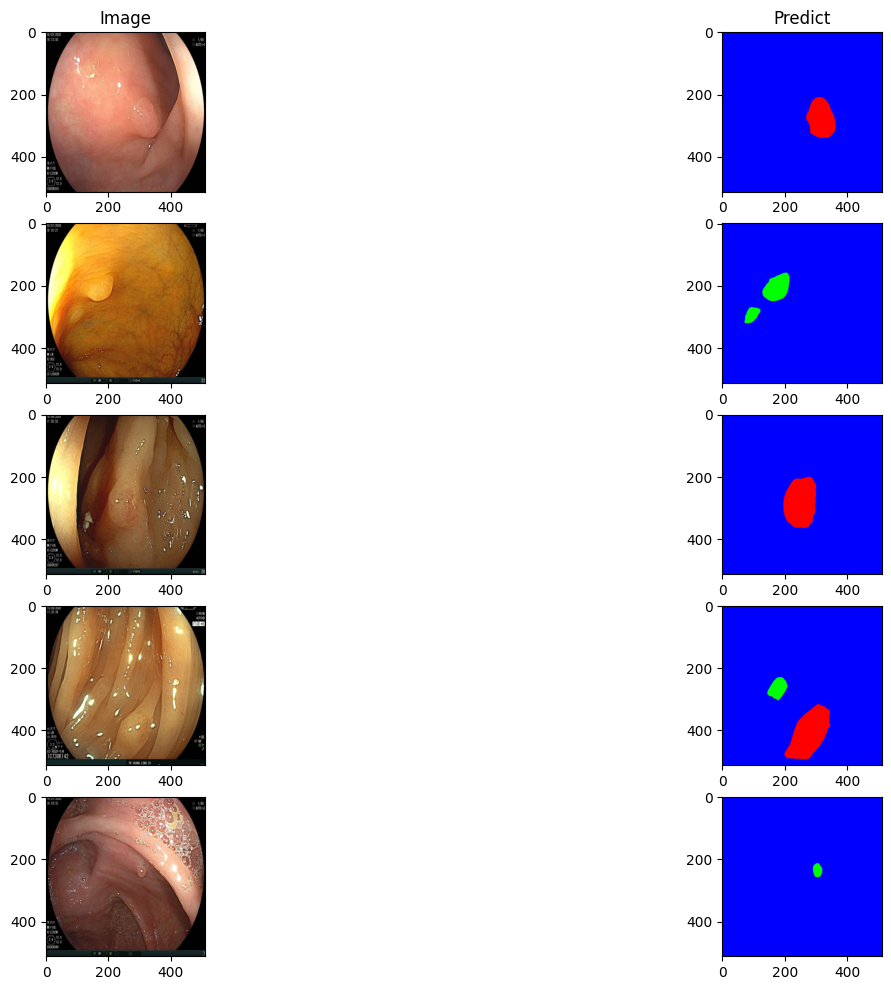

In [14]:
for i, (data, path, h, w) in enumerate(test_dataloader):
    img = data
    break
print(img.shape)
fig, arr = plt.subplots(5, 2, figsize=(16, 12))
arr[0][0].set_title('Image');
arr[0][1].set_title('Predict');

model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(5):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    arr[i][1].imshow(F.one_hot(torch.argmax(predict[i], 0).cpu(), 3).float())